## Deep Learning based Joke Recommender Systems
- Data source: Jester 1.7M jokes ratings dataset.
- https://www.kaggle.com/datasets/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset
- The dataset contains over 1.7 million continuous ratings (-10.00 to +10.00) of 140 jokes from 59,132 users.
- The dataset is collected between November 2006 - May 2009.

In [39]:
# !pip install pytorch-lightning

In [40]:
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

np.random.seed(123)

In [41]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
df = pd.read_csv('/content/drive/My Drive/Machine Learning/Final_Project/jester_ratings.csv')

In [44]:
items= pd.read_csv("/content/drive/My Drive/Machine Learning/Final_Project/jester_items.csv")

In [45]:
items.duplicated().sum()

0

In [46]:
items["length"] = items["jokeText"].str.len()

In [47]:
items["prepared_jokeText"] = items["jokeText"].apply(lambda x: word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", x.lower())))
items["prepared_jokeText"] = items["prepared_jokeText"].apply(lambda words: [w for w in words if w not in stopwords.words("english")])
items["prepared_jokeText"] = items["prepared_jokeText"].apply(lambda words: [WordNetLemmatizer().lemmatize(w, pos="v") for w in words])
items.head()

,jokeId,jokeText,length,prepared_jokeText
0,1,"A man visits the doctor. The doctor says ""I ha...",163,"[man, visit, doctor, doctor, say, bad, news, c..."
1,2,This couple had an excellent relationship goin...,383,"[couple, excellent, relationship, go, one, day..."
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA...,88,"[q, 200, feet, long, 4, teeth, front, row, wil..."
3,4,Q. What's the difference between a man and a t...,111,"[q, difference, man, toilet, toilet, follow, a..."
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...,95,"[q, j, simpson, internet, address, slash, slas..."


In [48]:
jokes_mean_rating = items.merge(df.groupby(["jokeId"]).mean().rating , on='jokeId', how='inner')
jokes_mean_rating.head()

,jokeId,jokeText,length,prepared_jokeText,rating
0,5,Q.\tWhat's O. J. Simpson's Internet address? \...,95,"[q, j, simpson, internet, address, slash, slas...",-1.756331
1,7,How many feminists does it take to screw in a ...,76,"[many, feminists, take, screw, light, bulb, fu...",-1.809230
2,8,Q. Did you hear about the dyslexic devil worsh...,84,"[q, hear, dyslexic, devil, worshiper, sell, so...",-0.672010
3,13,They asked the Japanese visitor if they have e...,101,"[ask, japanese, visitor, elections, country, e...",-0.590224
4,15,Q: What did the blind person say when given s...,88,"[q, blind, person, say, give, matzah, hell, wr...",-1.377098


In [49]:
positive = jokes_mean_rating[jokes_mean_rating["rating"] > 0]
negative = jokes_mean_rating[jokes_mean_rating["rating"] < 0]

def word_list(joke_data):
    
    list_of_words = []
    
    for list in joke_data["prepared_jokeText"]:
        for word in list:
            list_of_words.append(word)
    return list_of_words

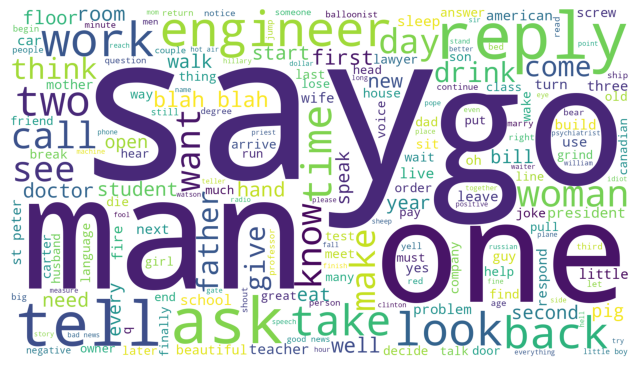

In [50]:
text = ' '.join([word for word in word_list(positive)])
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(cloud)

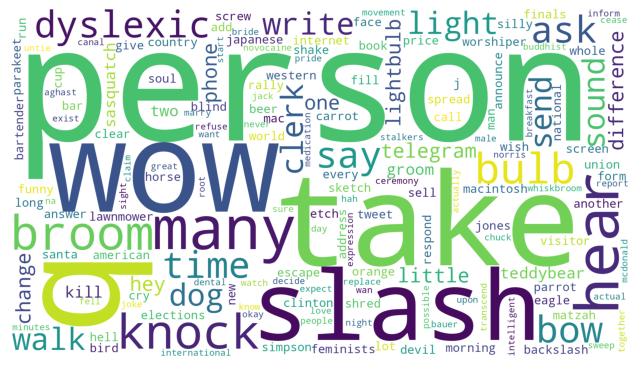

In [51]:
text = ' '.join([word for word in word_list(negative)])
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(cloud)

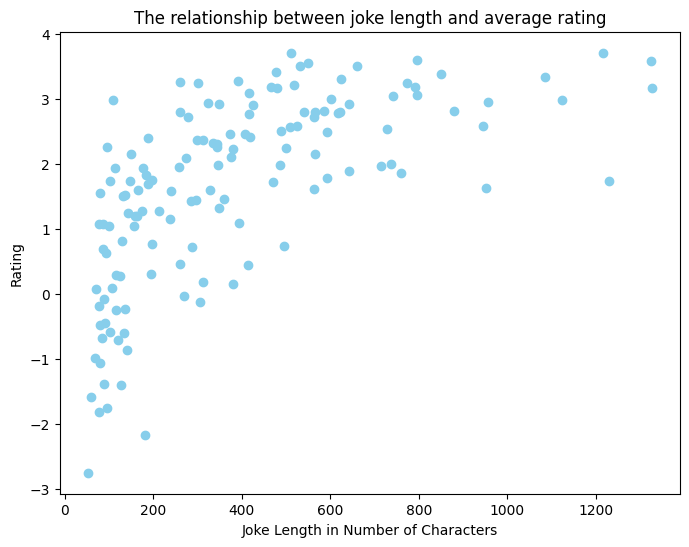

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(jokes_mean_rating["length"], jokes_mean_rating["rating"], label="Data", color="skyblue")
plt.xlabel("Joke Length in Number of Characters")
plt.ylabel("Rating")
plt.title("The relationship between joke length and average rating")

plt.show()

Text(0.5, 1.0, 'Distribution of the Text Length')

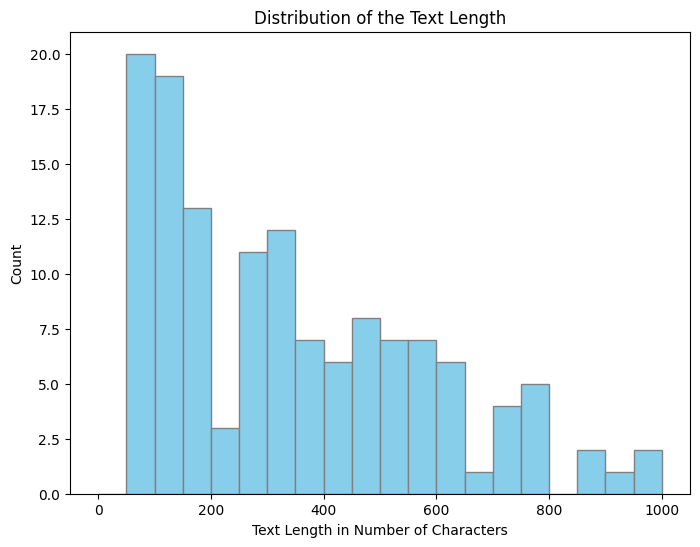

In [53]:
plt.figure(figsize=(8,6))
jokes_mean_rating["length"].hist(range=(0,1000), bins=20, color="skyblue", edgecolor = 'grey', linewidth=1)
plt.grid(False)
plt.xlabel("Text Length in Number of Characters")
plt.ylabel("Count")
plt.title("Distribution of the Text Length")

In [54]:
# Best rated joke
best_joke = jokes_mean_rating[jokes_mean_rating["rating"] == jokes_mean_rating["rating"].max()]
print(f'{best_joke.iloc[0].jokeText}')

One Sunday morning William burst into the living room and said,
"Dad! Mom! I have some great news for you! I am getting married
to the most beautiful girl in town. She lives a block away and
her name is Susan."
After dinner, William's dad took him aside. "Son, I have to talk
with you. Your mother and I have been married 30 years.. She's a
wonderful wife but she has never offered much excitement in the
bedroom, so I used to fool around with women a lot. Susan is
actually your half-sister, and I'm afraid you can't marry her."
William was heart-broken. After eight months he eventually
started dating girls again. A year later he came home and very
proudly announced, "Dianne said yes! We're getting married in
June."
Again his father insisted on another private conversation and
broke the sad news. "Dianne is your half-sister too, William. I'm
awfully sorry about this."
William was furious! He finally decided to go to his mother with
the news.
"Dad has done so much harm.. I guess I'm never go

In [55]:
df.sample(10)

,userId,jokeId,rating
675314,28666,45,3.062
487425,18668,127,-6.906
1408893,50167,15,0.781
423989,16530,55,0.188
197708,6340,33,-4.688
926230,36079,136,-7.625
886340,34966,72,2.188
493119,18835,84,7.000
1055984,39552,62,6.188
135967,3784,68,-0.188


In [56]:
df.isna().sum()

userId    0
jokeId    0
rating    0
dtype: int64

In [57]:
# Check if there is more than 1 rating given to the same joke by the same user
len(df.groupby(['userId','jokeId'])['rating'].count())/len(df) == 1

True

<function matplotlib.pyplot.show(close=None, block=None)>

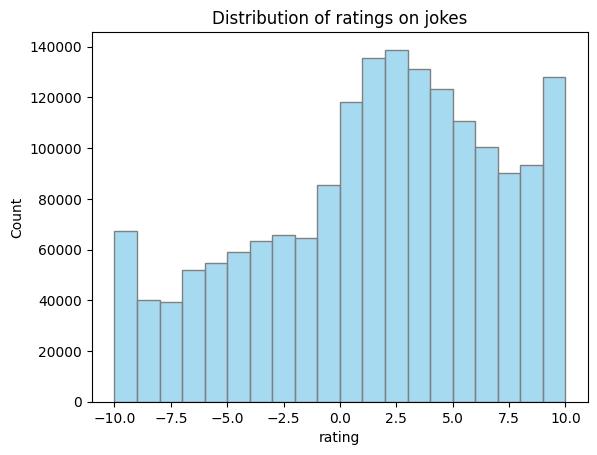

In [58]:
sns.histplot(df['rating'], bins = 20, color="skyblue", edgecolor = 'grey')
plt.title('Distribution of ratings on jokes')
plt.show

In [59]:
len(df.userId.unique())

59132

In [60]:
len(df.jokeId.unique())

140

In [61]:
print(f'There are {len(df)} rows of data from {len(df.userId.unique())} users on total of {len(df.jokeId.unique())} jokes.')

There are 1761439 rows of data from 59132 users on total of 140 jokes.


####1. Preprocess data and split into train/ test Dataset

- We want to leave only the top 50% high rating for each user.


In [62]:
# Sort the DataFrame by user and rating in descending order
df_sorted = df.sort_values(['userId', 'rating'], ascending=[True, False])

# Calculate the threshold for the top 50% ratings
threshold = df_sorted.groupby('userId')['rating'].quantile(0.50)

# Create a new column "interested" based on the threshold
df['interested'] = df.apply(lambda row: int(row['rating'] >= threshold[row['userId']]), axis=1)

In [63]:
df = df.query('interested == 1').copy()

In [64]:
print(f'There are {len(df)} rows of data from {len(df.userId.unique())} users on total of {len(df.jokeId.unique())} jokes.')

There are 906165 rows of data from 59132 users on total of 140 jokes.


- The number of users and jokes isn't changed, just the total rating decrease from 1,761,439 to 906,165.

- Train test split:  
we assume that the record is from earliest to latest, so the last record for a certain user is the last rating this user gave. And we are using the 'leave one out' method to split the train/test data.

In [65]:
df['order'] = df.groupby('userId')['rating'].cumcount() + 1
# check if the order looks ok for different users
# df.query('userId == 3') 

df['rank_latest'] = df.groupby(['userId'])['order'] \
                                .rank(method='first', ascending=False)
df.head()

,userId,jokeId,rating,interested,order,rank_latest
15,1,89,9.812,1,1,31.0
16,1,50,9.906,1,2,30.0
19,1,104,2.938,1,3,29.0
20,1,105,2.000,1,4,28.0
22,1,107,2.031,1,5,27.0


In [66]:
train_ratings = df[df['rank_latest'] != 1]
test_ratings = df[df['rank_latest'] == 1]
# drop columns that we no longer need ('order','rank_latest', 'interested')
train_ratings = train_ratings.drop(['order','rank_latest','interested'], axis=1)
test_ratings = test_ratings.drop(['order','rank_latest','interested'], axis=1)

In [67]:
print(f'shape of train data: {train_ratings.shape}')
print(f'shape of test data: {test_ratings.shape}')

shape of train data: (847033, 3)
shape of test data: (59132, 3)


####1. Converting from explicit (continuous) to implicit (binary class)

In [68]:
# Get a list of all joke IDs
all_jokeIds = df['jokeId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['jokeId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_jokeIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_jokeIds)
        users.append(u)
        items.append(negative_item)

  0%|          | 0/847033 [00:00<?, ?it/s]

In [69]:
class JokeTrainDataset(Dataset):
    """Jester Joke PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the joke ratings
        all_jokeIds (list): List containing all jokeIds
    
    """

    def __init__(self, ratings, all_jokeIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_jokeIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_jokeIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['jokeId']))


        num_negatives = 3
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_jokeIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_jokeIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [70]:
import torch.nn.functional as F

class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the joke ratings for training
            all_jokeIds (list): List containing all jokeIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_jokeIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=12)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=12)
        self.fc1 = nn.Linear(in_features=24, out_features=96)
        self.fc2 = nn.Linear(in_features=96, out_features=48)
        self.fc3 = nn.Linear(in_features=48, out_features=24)
        self.fc4 = nn.Linear(in_features=24, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=1)
        self.dropout = nn.Dropout(p=0.2)
        self.ratings = ratings
        self.all_jokeIds = all_jokeIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concatenate the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layers with activation functions and dropout
        vector = self.dropout(F.relu(self.fc1(vector)))
        vector = self.dropout(F.leaky_relu(self.fc2(vector)))
        vector = self.dropout(F.tanh(self.fc3(vector)))
        vector = self.dropout(F.relu(self.fc4(vector)))

        # Output layer
        pred = torch.sigmoid(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = F.binary_cross_entropy(predicted_labels, labels.view(-1, 1).float())
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(JokeTrainDataset(self.ratings, self.all_jokeIds),
                          batch_size=512, num_workers=4)

In [71]:
num_users = df['userId'].max()+1
num_items = df['jokeId'].max()+1

all_jokeIds = df['jokeId'].unique()

model = NCF(num_users, num_items, train_ratings, all_jokeIds)

In [72]:
trainer = pl.Trainer(
    max_epochs=5,
    reload_dataloaders_every_n_epochs=1,
    logger=False
)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 767 K 
1 | item_embedding | Embedding | 1.8 K 
2 | fc1            | Linear    | 2.4 K 
3 | fc2            | Linear    | 4.7 K 
4 | fc3            | Linear    | 1.2 K 
5 | fc4            | Linear    | 300   
6 | output         | Linear    | 13    
7 | dropout      

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [73]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['jokeId']))

# Dict of all items that user are interested
user_interested_items = df.groupby('userId')['jokeId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interested_items = user_interested_items[u]
    not_interested_items = set(all_jokeIds) - set(interested_items)
    selected_not_interested = list(np.random.choice(list(not_interested_items), 99))
    test_items = selected_not_interested + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/59132 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.84


- Reference:  
  - https://goldberg.berkeley.edu/pubs/eigentaste.pdf
  - https://github.com/guoyang9/NCF/blob/master/model.py
  - https://www.kaggle.com/code/jamesloy/deep-learning-based-recommender-systems/notebook  
  - https://www.kaggle.com/code/viktoriaw/this-is-why-your-jokes-aren-t-funny